In [346]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, BaggingRegressor, RandomForestRegressor
from sklearn import svm
import xgboost
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [325]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

print('test_Data_set length : ', len(test), ', train_Data_set length : ', len(train))

test_Data_set length :  6493 , train_Data_set length :  10886


## data prossessing 

- datetime 을 month, day, hour, year 로 분할

In [326]:
test['month'] = pd.to_datetime(test['datetime']).dt.month
test['day'] = pd.to_datetime(test['datetime']).dt.day
test['hour'] = pd.to_datetime(test['datetime']).dt.hour
test['year'] = pd.to_datetime(test['datetime']).dt.year
test = test.drop(['datetime'], axis = 1)


train['month'] = pd.to_datetime(train['datetime']).dt.month
train['day'] = pd.to_datetime(train['datetime']).dt.day
train['hour'] = pd.to_datetime(train['datetime']).dt.hour
train['year'] = pd.to_datetime(train['datetime']).dt.year
train = train.drop(['datetime'], axis = 1)


- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- season -  1 = 1, 2, 3 month , 2 = 4, 5, 6 month, 3 = 7, 8, 9 month, 4 = 10, 11, 12 month
- 12, 1, 2 월을 겨울로 바꾸고 3달씩 시즌을 변경했다.
- data prossessing

In [327]:
test.loc[(test['month'] == 12) | (test['month'] == 1 ) | (test['month'] == 2),'season' ] = 4
test.loc[(test['month'] == 3) | (test['month'] == 4 ) | (test['month'] == 5),'season' ] = 1
test.loc[(test['month'] == 6) | (test['month'] == 7 ) | (test['month'] == 8),'season' ] = 2
test.loc[(test['month'] == 9) | (test['month'] == 10 ) | (test['month'] == 11),'season' ] = 3
x_test = test

train.loc[(test['month'] == 12) | (train['month'] == 1 ) | (train['month'] == 2),'season' ] = 4
train.loc[(test['month'] == 3) | (train['month'] == 4 ) | (train['month'] == 5),'season' ] = 1
train.loc[(test['month'] == 6) | (train['month'] == 7 ) | (train['month'] == 8),'season' ] = 2
train.loc[(test['month'] == 9) | (train['month'] == 10 ) | (train['month'] == 11),'season' ] = 3

In [328]:
train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour,year
0,4,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,1,0,2011
1,4,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1,2011
2,4,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,1,2,2011
3,4,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,1,3,2011
4,4,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,1,4,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,12,19,19,2012
10882,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,12,19,20,2012
10883,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,12,19,21,2012
10884,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,12,19,22,2012


- train data feature selection
- train set의 casual, registerd 은 등록과 미등록 데이터이기 때문에 count 와 상관관계가 높게 나온다

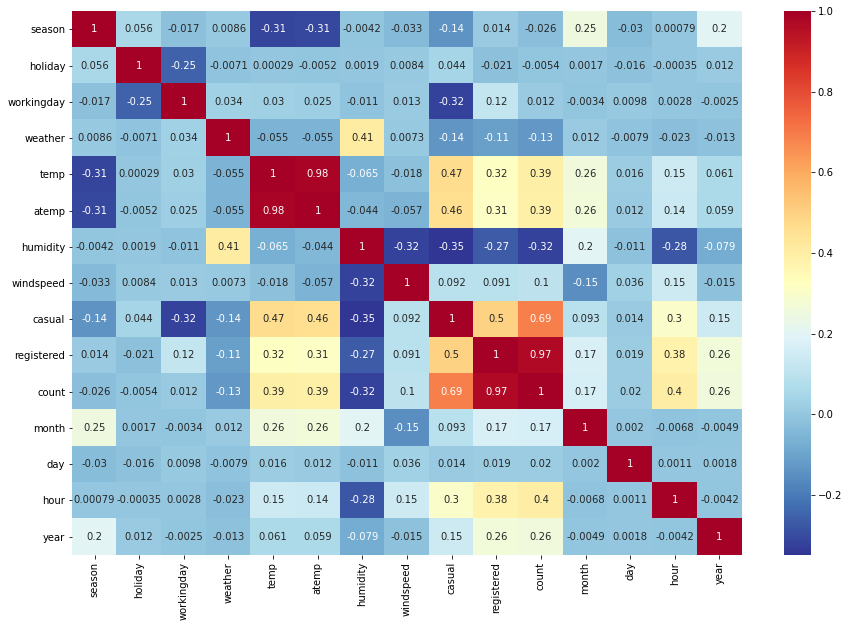

In [329]:
plt.figure(figsize = (15,10))
sns.heatmap(cor, cmap = 'RdYlBu_r', annot = True )
plt.show()

In [330]:
feature_cols = train.columns.difference(['count','casual','registered'])
y_train = train['count'].copy()
x_train = train[feature_cols].copy()


In [331]:
cat_cols = ['day', 'holiday', 'hour', 'month', 'season', 'weather', 'workingday', 'year']
num_cols = ['atemp', 'humidity', 'temp']

In [332]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [333]:
LE = LabelEncoder()
for col in cat_cols:
    x_train.loc[:,col] = LE.fit_transform(x_train.loc[:,col])
scaler = StandardScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])

In [334]:
x_train

,atemp,day,holiday,hour,humidity,month,season,temp,weather,windspeed,workingday,year
0,-1.092737,0,0,0,0.993213,0,3,-1.333661,0,0.0000,0,0
1,-1.182421,0,0,1,0.941249,0,3,-1.438907,0,0.0000,0,0
2,-1.182421,0,0,2,0.941249,0,3,-1.438907,0,0.0000,0,0
3,-1.092737,0,0,3,0.681430,0,3,-1.333661,0,0.0000,0,0
4,-1.092737,0,0,4,0.681430,0,3,-1.333661,0,0.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,-0.467310,18,0,19,-0.617666,11,3,-0.596935,0,26.0027,1,1
10882,-0.735182,18,0,20,-0.253919,11,3,-0.702182,0,15.0013,1,1
10883,-0.913959,18,0,21,-0.046064,11,3,-0.807428,0,15.0013,1,1
10884,-0.735182,18,0,22,-0.046064,11,3,-0.807428,0,6.0032,1,1


In [335]:
x_test = test.copy()

In [336]:
LE = LabelEncoder()
for col in cat_cols:
    x_test.loc[:,col] = LE.fit_transform(x_test.loc[:,col])
scaler = StandardScaler()
x_test[num_cols] = scaler.fit_transform(x_test[num_cols])

In [337]:
x_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour,year
0,3,0,1,0,-1.235966,-1.440193,-0.421172,26.0027,0,0,0,0
1,3,0,1,0,-1.235966,-1.181711,-0.421172,0.0000,0,0,1,0
2,3,0,1,0,-1.235966,-1.181711,-0.421172,0.0000,0,0,2,0
3,3,0,1,0,-1.235966,-1.267682,-0.421172,11.0014,0,0,3,0
4,3,0,1,0,-1.235966,-1.267682,-0.421172,11.0014,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,3,0,1,1,-1.235966,-1.267682,-0.213831,11.0014,11,11,19,1
6489,3,0,1,1,-1.235966,-1.267682,-0.213831,11.0014,11,11,20,1
6490,3,0,1,0,-1.235966,-1.267682,-0.213831,11.0014,11,11,21,1
6491,3,0,1,0,-1.235966,-1.181711,-0.421172,8.9981,11,11,22,1


- ensemble RandomForest

In [342]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train, test_size = 0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(8708, 12) (2178, 12) (8708,) (2178,)


In [347]:
RF = RandomForestRegressor().fit(X_train,Y_train)
RF.score(X_test,Y_test)

In [349]:
lr = LinearRegression().fit(X_train,Y_train)
Y_pred = lr.predict(X_test)
lr.score(X_test,Y_test)

0.39821001905226094

In [354]:
# Linear Regression + Bagging sampling
LR_Bagging = BaggingRegressor(
    base_estimator=LinearRegression()).fit(X_train,Y_train)
LR_Bagging.score(X_test,Y_test)

0.3981181723182977

- ridge Regression

In [355]:
ridge = Ridge().fit(X_train,Y_train)
ridge.score(X_train,Y_train)

0.3868064645632707

- lasso Regression

In [356]:
lasso = Lasso().fit(X_train,Y_train)
lasso.score(X_train,Y_train)

0.38653130052221496

In [357]:
xgb = xgboost.XGBRegressor().fit(X_train,Y_train)
y_pred = xgb.predict(X_test)
xgb.score(X_test,Y_test)

0.9522957511858512

In [358]:
y_pred = round(pd.DataFrame(y_pred, columns = ['count']),0).astype('int64')

In [359]:
y_pred

,count
0,26
1,279
2,183
3,368
4,7
...,...
2173,6
2174,16
2175,215
2176,240


In [360]:
test = pd.read_csv('test.csv')
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [361]:
submission = pd.concat([test['datetime'],y_pred], axis = 1)
submission.to_csv('submission_xgboost.csv')